# Comparing receptive fields

In [0]:
import random as rn

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow import nn
from tensorflow.keras import initializers
from tensorflow.keras.utils import Progbar

In [0]:
# Defining random seeds
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)
rn.seed(random_seed)

In [0]:
class MaskedConv2D(keras.layers.Layer):
    """Convolutional layers with masks for Gated PixelCNN.

    Masked convolutional layers used to implement Vertical and Horizontal
    stacks of the Gated PixelCNN.

    Note: This implementation is different from the normal PixelCNN.

    Arguments:
    mask_type: one of `"V"`, `"A"` or `"B".`
    filters: Integer, the dimensionality of the output space
        (i.e. the number of output filters in the convolution).
    kernel_size: An integer or tuple/list of 2 integers, specifying the
        height and width of the 2D convolution window.
        Can be a single integer to specify the same value for
        all spatial dimensions.
    strides: An integer or tuple/list of 2 integers,
        specifying the strides of the convolution along the height and width.
        Can be a single integer to specify the same value for
        all spatial dimensions.
        Specifying any stride value != 1 is incompatible with specifying
        any `dilation_rate` value != 1.
    padding: one of `"valid"` or `"same"` (case-insensitive).
    kernel_initializer: Initializer for the `kernel` weights matrix.
    bias_initializer: Initializer for the bias vector.
    """

    def __init__(self,
                 mask_type,
                 filters,
                 kernel_size,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros'):
        super(MaskedConv2D, self).__init__()

        assert mask_type in {'A', 'B', 'V'}
        self.mask_type = mask_type

        self.filters = filters

        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        self.kernel_size = kernel_size

        self.strides = strides
        self.padding = padding.upper()
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

    def build(self, input_shape):
        kernel_h, kernel_w = self.kernel_size

        self.kernel = self.add_weight('kernel',
                                      shape=(kernel_h,
                                             kernel_w,
                                             int(input_shape[-1]),
                                             self.filters),
                                      initializer=self.kernel_initializer,
                                      trainable=True)

        self.bias = self.add_weight('bias',
                                    shape=(self.filters,),
                                    initializer=self.bias_initializer,
                                    trainable=True)

        mask = np.ones(self.kernel.shape, dtype=np.float32)

        if kernel_h % 2 != 0: 
            center_h = kernel_h // 2
        else:
            center_h = (kernel_h - 1) // 2

        if kernel_w % 2 != 0: 
            center_w = kernel_w // 2
        else:
            center_w = (kernel_w - 1) // 2

        if self.mask_type == 'V':
            mask[center_h + 1:, :, :, :] = 0.
        else:
            mask[:center_h, :, :] = 0.
            mask[center_h, center_w + (self.mask_type == 'B'):, :, :] = 0.
            mask[center_h + 1:, :, :] = 0.          

        self.mask = tf.constant(mask, dtype=tf.float32, name='mask')

    def call(self, input):
        masked_kernel = tf.math.multiply(self.mask, self.kernel)
        x = nn.conv2d(input,
                      masked_kernel,
                      strides=[1, self.strides, self.strides, 1],
                      padding=self.padding)
        x = nn.bias_add(x, self.bias)
        return x

In [0]:
class GatedBlock(tf.keras.Model):
    """ Gated block of the Gated PixelCNN."""

    def __init__(self, mask_type, filters, kernel_size):
        super(GatedBlock, self).__init__(name='')

        self.mask_type = mask_type
        self.vertical_conv = MaskedConv2D(mask_type='V',
                                          filters=2 * filters,
                                          kernel_size=kernel_size)
        
        self.horizontal_conv = MaskedConv2D(mask_type=mask_type,
                                            filters=2 * filters,
                                            kernel_size=kernel_size)

        self.padding = keras.layers.ZeroPadding2D(padding=((1,0),0))
        self.cropping = keras.layers.Cropping2D(cropping=((0, 1), 0))

        self.v_to_h_conv = keras.layers.Conv2D(filters=2 * filters, kernel_size=1)

        self.horizontal_output = keras.layers.Conv2D(filters=filters, kernel_size=1)

    def _gate(self, x):
        tanh_preactivation, sigmoid_preactivation = tf.split(x, 2, axis=-1)
        return tf.nn.tanh(tanh_preactivation) * tf.nn.sigmoid(sigmoid_preactivation)

    def call(self, input_tensor):
        v = input_tensor[0]
        h = input_tensor[1]

        vertical_preactivation = self.vertical_conv(v)  # NxN

        # Shifting feature map down to ensure causality
        v_to_h = self.padding(vertical_preactivation)
        v_to_h = self.cropping(v_to_h)
        v_to_h = self.v_to_h_conv(v_to_h)  # 1x1

        horizontal_preactivation = self.horizontal_conv(h)  # 1xN
        
        v_out = self._gate(vertical_preactivation)

        horizontal_preactivation = horizontal_preactivation + v_to_h
        h_activated = self._gate(horizontal_preactivation)
        h_activated = self.horizontal_output(h_activated)

        if self.mask_type == 'A':
            h_out = h_activated
        elif self.mask_type == 'B':
            h_out = h + h_activated

        return v_out, h_out

In [0]:
def plot_receptive_field(model, data):
    out = model(data)

    with tf.GradientTape() as tape:
        tape.watch(data)
        prediction = model(data)
        loss = prediction[:,5,5,0]

    gradients = tape.gradient(loss, data)

    gradients = np.abs(gradients.numpy().squeeze())
    gradients = (gradients > 1e-8).astype('float32')
    gradients[5, 5] = 0.5

    plt.figure()
    plt.imshow(gradients)
    plt.title(f'Receptive field from pixel layers')
    plt.show()

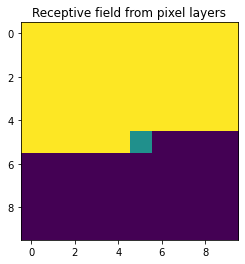

In [0]:
inputs = keras.layers.Input(shape=(height, width, n_channel))
v, h = GatedBlock(mask_type='A', filters=1, kernel_size=3)([inputs, inputs])
v, h = GatedBlock(mask_type='B', filters=1, kernel_size=3)([v, h])
v, h = GatedBlock(mask_type='B', filters=1, kernel_size=3)([v, h])
v, h = GatedBlock(mask_type='B', filters=1, kernel_size=3)([v, h])
v, h = GatedBlock(mask_type='B', filters=1, kernel_size=3)([v, h])
model = tf.keras.Model(inputs=inputs, outputs=h)

data = tf.random.normal((1,10,10,1))

plot_receptive_field(model, data)